This notebook produces plots and evaluation metrics from the predictions for models with and without physics inputs.

#Input parameters here

In [ ]:
# # PARAMETERS # # 
BASE_DIR = '/content/drive/My Drive/CS230_FinalReport/' # your base directory
MASK_VALUE = 999.
# # # # # # # # # # 

# Load libraries and other set up

In [ ]:
# Mount Drive to access data.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

# To import own model modules
#import sys
#sys.path.insert(0, (os.path.join(BASE_DIR, 'src/visualization')))
#from analyze_preds_3dvec_utils import *

In [ ]:
# Load in predictions and Y_test and append

Y_pred_withphysics = np.load(file=os.path.join(BASE_DIR, 'models', 'with_physicsinputs', 'transformed_preds', 'Y_pred_3d.npy'), allow_pickle=True)
Y_pred_withoutphysics = np.load(file=os.path.join(BASE_DIR, 'models', 'without_physicsinputs', 'transformed_preds', 'Y_pred_3d.npy'), allow_pickle=True)
Y_true = np.load(file=os.path.join(BASE_DIR, 'models', 'with_physicsinputs', 'transformed_preds', 'Y_true_3d.npy'), allow_pickle=True) # same for each

# Separate oagr and acl data
Y_pred_withphysics_oagr = Y_pred_withphysics[0:700,:,:]
Y_pred_withoutphysics_oagr = Y_pred_withoutphysics[0:700,:,:]
Y_true_oagr = Y_true[0:700,:,:]

Y_pred_withphysics_acl = Y_pred_withphysics[700:805,:,:]
Y_pred_withoutphysics_acl = Y_pred_withoutphysics[700:805,:,:]
Y_true_acl = Y_true[700:805,:,:]


#Original

In [ ]:
# Loop thru each dataset and create plots for each subject and task

# Store output names.
out_node_names = ['R GRF x','R GRF y','R GRF z',
                  'L GRF x','L GRF y','L GRF z',
                  'R GRM x','R GRM y','R GRM z',
                  'L GRM x','L GRM y','L GRM z']

plot_savedir = os.path.join(BASE_DIR, 'reports','figures', 'combined')

In [ ]:
# # OAGR # #
num_subjs = 7
num_trials = 100
# loop over 7 test subjects, and get all steps per subj
for s in range(num_subjs):
    
    Y_pred_allfeats_withphysics = Y_pred_withphysics_oagr[num_trials*s:num_trials*(s+1), :, :] # shape = 100 x 67 x 12
    Y_pred_allfeats_withoutphysics = Y_pred_withoutphysics_oagr[num_trials*s:num_trials*(s+1), :, :]
    Y_true_allfeats = Y_true_oagr[num_trials*s:num_trials*(s+1), :, :]
    
    # Identify the minimum where masking/padding started for the given subject over all trials for given task.
    min_timestep = np.min(np.nonzero(Y_true_allfeats == MASK_VALUE)[1])
    
    # Create subplots for all the outputs for each subject.
    fig, axs = plt.subplots(4, 3, figsize=(15,15))
    fig.suptitle(f"OAGR Subject {s}")
    
    for f in range(12): # loop over all features
        
        # Subset Y_pred and Y_true based on min timesteps and given feature.
        Y_pred_withphysics = Y_pred_allfeats_withphysics[:,0:min_timestep,f] # shape = 100, unmasked time range, 1 feature
        Y_pred_withoutphysics = Y_pred_allfeats_withoutphysics[:,0:min_timestep,f] 
        Y_true = Y_true_allfeats[:,0:min_timestep,f]
            
        # # PLOTTING # #
        # Add to subplots:
        if f < 3: row = 0
        elif f < 6: row = 1
        elif f < 9: row = 2
        else: row = 3
        
        Y_pred_mean_withphysics = np.mean(Y_pred_withphysics,axis=0)
        Y_pred_std_withphysics = np.std(Y_pred_withphysics,axis=0)
        Y_pred_mean_withoutphysics = np.mean(Y_pred_withoutphysics,axis=0)
        Y_pred_std_withoutphysics = np.std(Y_pred_withoutphysics,axis=0)
        Y_true_mean = np.mean(Y_true,axis=0)
        Y_true_std = np.std(Y_true,axis=0)
        
        # Plot with physics
        axs[row, f%3].plot(Y_pred_mean_withphysics,color='#f781bf',label='prediction (physics)')
        axs[row, f%3].fill_between(range(len(Y_pred_mean_withphysics)), Y_pred_mean_withphysics-Y_pred_std_withphysics, Y_pred_mean_withphysics+Y_pred_std_withphysics,
                                    alpha=0.5, edgecolor='#f781bf', facecolor='#f781bf', linewidth=0)
        # Plot without physics
        axs[row, f%3].plot(Y_pred_mean_withoutphysics,color='#984ea3',label='prediction (no physics)')
        axs[row, f%3].fill_between(range(len(Y_pred_mean_withoutphysics)), Y_pred_mean_withoutphysics-Y_pred_std_withoutphysics, Y_pred_mean_withoutphysics+Y_pred_std_withoutphysics,
                                    alpha=0.5, edgecolor='#984ea3', facecolor='#984ea3', linewidth=0)
        # Plot true
        axs[row, f%3].plot(np.mean(Y_true,axis=0),color='#4daf4a',label='true')
        axs[row, f%3].fill_between(range(len(Y_true_mean)), Y_true_mean-Y_true_std, Y_true_mean+Y_true_std,
                                    alpha=0.5, edgecolor='#4daf4a', facecolor='#4daf4a', linewidth=0)
        
        axs[row, f%3].set_title(out_node_names[f])
        if f == 0:
          #axs[row, f%3].legend(['prediction','true'])
          axs[row, f%3].legend()
        if row == 3:
          axs[row, f%3].set_xlabel('timesteps')
        if (row == 0 or row == 1) and f%3 == 0:
          axs[row, f%3].set_ylabel('BW')
        if (row == 2 or row == 3) and f%3 == 0:
          axs[row, f%3].set_ylabel('BW*Ht')  
        
          
    # Save figure for each subject.
    figname = 'transformed_preds_oagr_subj' + str(s) + '.png'
    plt.savefig(os.path.join(plot_savedir, figname))


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# # ACL # #
num_subjs = 7
num_trials = 3
acl_tasks = ['_cutting','_dj','_lldj','_rldj','_unant_cut']

# loop over test subjects, and get all steps per subj
for s in range(num_subjs):
    
    # Subset data by subject
    Y_pred_allsubjtasks_withphysics = Y_pred_withphysics_acl[num_trials*5*s:num_trials*5*(s+1), :, :] # shape = 15 x 67 x 12
    Y_pred_allsubjtasks_withoutphysics = Y_pred_withoutphysics_acl[num_trials*5*s:num_trials*5*(s+1), :, :] # shape = 15 x 67 x 12
    Y_true_allsubjtasks = Y_true_acl[num_trials*5*s:num_trials*5*(s+1), :, :]
    
    for task in range(5): # 5 tasks
    
        # Subset data by task.
        Y_pred_allfeats_withphysics = Y_pred_allsubjtasks_withphysics[num_trials*task:num_trials*(task+1),:,:] #  shape = 3 x 67 x 12
        Y_pred_allfeats_withoutphysics = Y_pred_allsubjtasks_withoutphysics[num_trials*task:num_trials*(task+1),:,:] #  shape = 3 x 67 x 12
        Y_true_allfeats = Y_true_allsubjtasks[num_trials*task:num_trials*(task+1),:,:]
    
    
        # Identify the minimum where masking/padding started for the given subject over all trials for given task.
        min_timestep = np.min(np.nonzero(Y_true_allfeats == MASK_VALUE)[1])
        
        # Create subplots for all the outputs for each subject and task.
        fig, axs = plt.subplots(4, 3, figsize=(15,15))
        fig.suptitle(f"ACL Subject {s}, {acl_tasks[task]}")
        
        for f in range(12): # loop over all features
            
            # Subset Y_pred and Y_true based on min timesteps and given feature.
            Y_pred_withphysics = Y_pred_allfeats_withphysics[:,0:min_timestep,f] # shape = 3, unmasked time range, 1 feature
            Y_pred_withoutphysics = Y_pred_allfeats_withoutphysics[:,0:min_timestep,f] # shape = 3, unmasked time range, 1 feature
            Y_true = Y_true_allfeats[:,0:min_timestep,f]
                        
            # # PLOTTING # #
            # Add to subplots:
            if f < 3: row = 0
            elif f < 6: row = 1
            elif f < 9: row = 2
            else: row = 3
        
            Y_pred_mean_withphysics = np.mean(Y_pred_withphysics,axis=0)
            Y_pred_std_withphysics = np.std(Y_pred_withphysics,axis=0)
            Y_pred_mean_withoutphysics = np.mean(Y_pred_withoutphysics,axis=0)
            Y_pred_std_withoutphysics = np.std(Y_pred_withoutphysics,axis=0)
            Y_true_mean = np.mean(Y_true,axis=0)
            Y_true_std = np.std(Y_true,axis=0)
            
            # With physics
            axs[row, f%3].plot(Y_pred_mean_withphysics,color='#f781bf',label='prediction (physics)')
            axs[row, f%3].fill_between(range(len(Y_pred_mean_withphysics)), Y_pred_mean_withphysics-Y_pred_std_withphysics, Y_pred_mean_withphysics+Y_pred_std_withphysics,
                                        alpha=0.5, edgecolor='#f781bf', facecolor='#f781bf', linewidth=0)
            # Without physics
            axs[row, f%3].plot(Y_pred_mean_withoutphysics,color='#984ea3',label='prediction (no physics)')
            axs[row, f%3].fill_between(range(len(Y_pred_mean_withoutphysics)), Y_pred_mean_withoutphysics-Y_pred_std_withoutphysics, Y_pred_mean_withoutphysics+Y_pred_std_withoutphysics,
                                        alpha=0.5, edgecolor='#984ea3', facecolor='#984ea3', linewidth=0)
            # True
            axs[row, f%3].plot(np.mean(Y_true,axis=0),color='#4daf4a',label='true')
            axs[row, f%3].fill_between(range(len(Y_true_mean)), Y_true_mean-Y_true_std, Y_true_mean+Y_true_std,
                                        alpha=0.5, edgecolor='#4daf4a', facecolor='#4daf4a', linewidth=0)
            
            axs[row, f%3].set_title(out_node_names[f])
            if f == 0:
              #axs[row, f%3].legend(['prediction','true'])
              axs[row, f%3].legend()
            if row == 3:
              axs[row, f%3].set_xlabel('timesteps')
            if (row == 0 or row == 1) and f%3 == 0:
              axs[row, f%3].set_ylabel('BW')
            if (row == 2 or row == 3) and f%3 == 0:
              axs[row, f%3].set_ylabel('BW*Ht')  
        
        # Save figure for each subject and task.
        figname = 'transformed_preds_acl_subj' + str(s) + acl_tasks[task] + '.png'
        plt.savefig(os.path.join(plot_savedir, figname))

Output hidden; open in https://colab.research.google.com to view.

#Redo with EAC practice talk feedback
- increase font size
- legend on y walking
- update header names
- use same y *scale*
- just run for first test subj in each

In [ ]:
# Loop thru each dataset and create plots for each subject and task

# Store output names.
out_node_names = ['medio-lateral','vertical','anterior-posterior',
                  'L GRF x','L GRF y','L GRF z',
                  'R GRM x','R GRM y','R GRM z',
                  'L GRM x','L GRM y','L GRM z']

plot_savedir = os.path.join(BASE_DIR, 'reports','figures', 'combined')

import matplotlib

matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

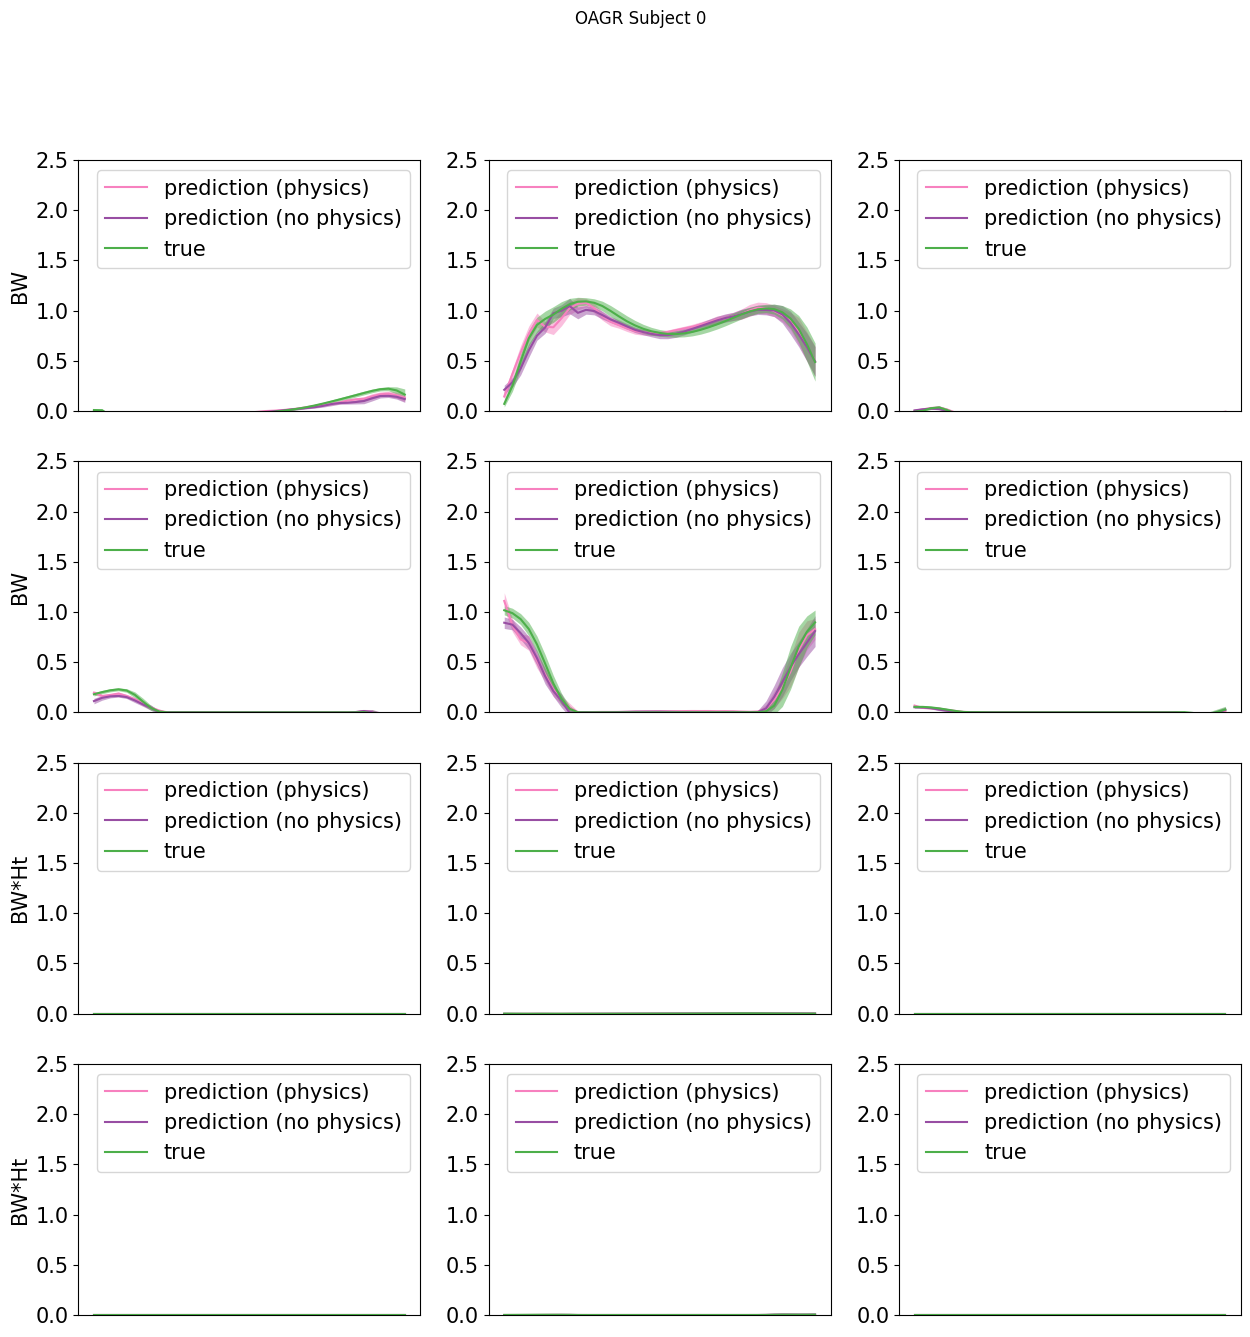

In [ ]:
# # OAGR # #
num_subjs = 1
num_trials = 100
# loop over 7 test subjects, and get all steps per subj
for s in range(num_subjs):
    
    Y_pred_allfeats_withphysics = Y_pred_withphysics_oagr[num_trials*s:num_trials*(s+1), :, :] # shape = 100 x 67 x 12
    Y_pred_allfeats_withoutphysics = Y_pred_withoutphysics_oagr[num_trials*s:num_trials*(s+1), :, :]
    Y_true_allfeats = Y_true_oagr[num_trials*s:num_trials*(s+1), :, :]
    
    # Identify the minimum where masking/padding started for the given subject over all trials for given task.
    min_timestep = np.min(np.nonzero(Y_true_allfeats == MASK_VALUE)[1])
    
    # Create subplots for all the outputs for each subject.
    fig, axs = plt.subplots(4, 3, figsize=(15,15))
    fig.suptitle(f"OAGR Subject {s}")
    plt.tick_params(axis='both', which='both', labelsize=15)
    
    for f in range(12): # loop over all features
        
        # Subset Y_pred and Y_true based on min timesteps and given feature.
        Y_pred_withphysics = Y_pred_allfeats_withphysics[:,0:min_timestep,f] # shape = 100, unmasked time range, 1 feature
        Y_pred_withoutphysics = Y_pred_allfeats_withoutphysics[:,0:min_timestep,f] 
        Y_true = Y_true_allfeats[:,0:min_timestep,f]
            
        # # PLOTTING # #
        # Add to subplots:
        if f < 3: row = 0
        elif f < 6: row = 1
        elif f < 9: row = 2
        else: row = 3
        
        Y_pred_mean_withphysics = np.mean(Y_pred_withphysics,axis=0)
        Y_pred_std_withphysics = np.std(Y_pred_withphysics,axis=0)
        Y_pred_mean_withoutphysics = np.mean(Y_pred_withoutphysics,axis=0)
        Y_pred_std_withoutphysics = np.std(Y_pred_withoutphysics,axis=0)
        Y_true_mean = np.mean(Y_true,axis=0)
        Y_true_std = np.std(Y_true,axis=0)
        
        # Plot with physics
        axs[row, f%3].plot(Y_pred_mean_withphysics,color='#f781bf',label='prediction (physics)')
        axs[row, f%3].fill_between(range(len(Y_pred_mean_withphysics)), Y_pred_mean_withphysics-Y_pred_std_withphysics, Y_pred_mean_withphysics+Y_pred_std_withphysics,
                                    alpha=0.5, edgecolor='#f781bf', facecolor='#f781bf', linewidth=0)
        # Plot without physics
        axs[row, f%3].plot(Y_pred_mean_withoutphysics,color='#984ea3',label='prediction (no physics)')
        axs[row, f%3].fill_between(range(len(Y_pred_mean_withoutphysics)), Y_pred_mean_withoutphysics-Y_pred_std_withoutphysics, Y_pred_mean_withoutphysics+Y_pred_std_withoutphysics,
                                    alpha=0.5, edgecolor='#984ea3', facecolor='#984ea3', linewidth=0)
        # Plot true
        axs[row, f%3].plot(np.mean(Y_true,axis=0),color='#4daf4a',label='true')
        axs[row, f%3].fill_between(range(len(Y_true_mean)), Y_true_mean-Y_true_std, Y_true_mean+Y_true_std,
                                    alpha=0.5, edgecolor='#4daf4a', facecolor='#4daf4a', linewidth=0)
        
        #axs[row, f%3].set_title(out_node_names[f])
        axs[row, f%3].legend(fontsize = 15)         
        #axs[row, f%3].set_xlabel('timesteps')
        axs[row, f%3].set_ylim([0,2.5])
        axs[row, f%3].set_xticks([])
        if (row == 0 or row == 1) and f%3 == 0:
          axs[row, f%3].set_ylabel('BW', fontsize = 15)
        if (row == 2 or row == 3) and f%3 == 0:
          axs[row, f%3].set_ylabel('BW*Ht', fontsize = 15)  
      
          
    # Save figure for each subject.
    figname = 'transformed_preds_oagr_subj' + str(s) + '.png'
    plt.savefig(os.path.join(plot_savedir, figname))

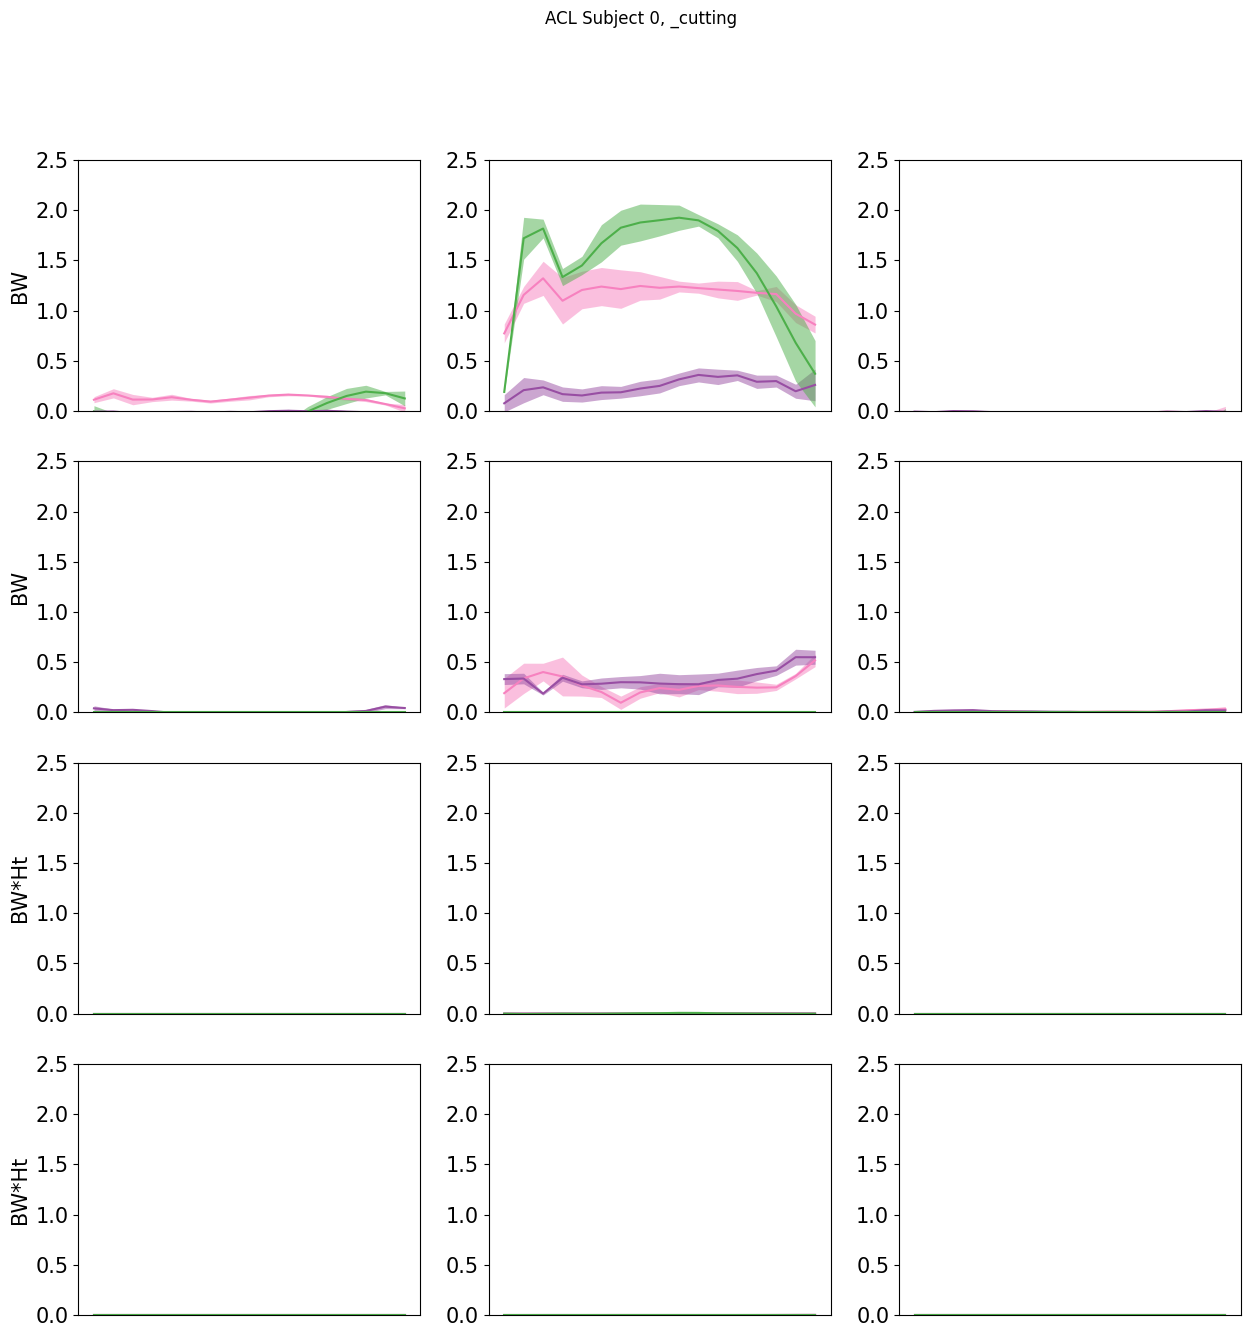

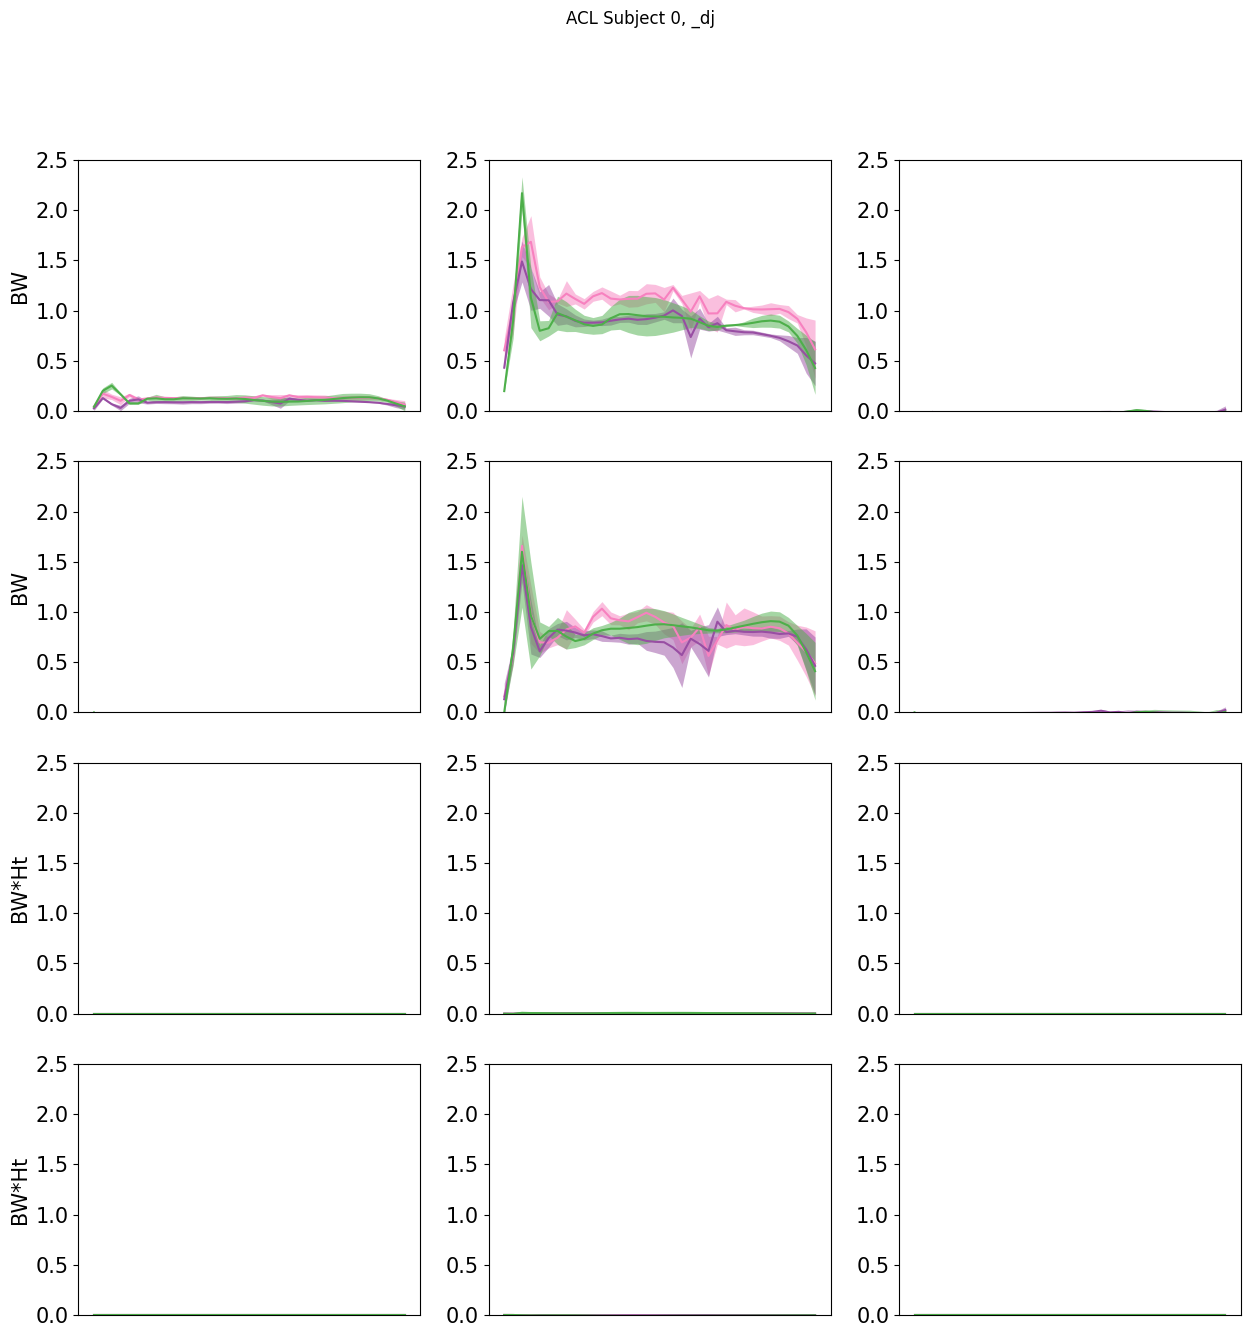

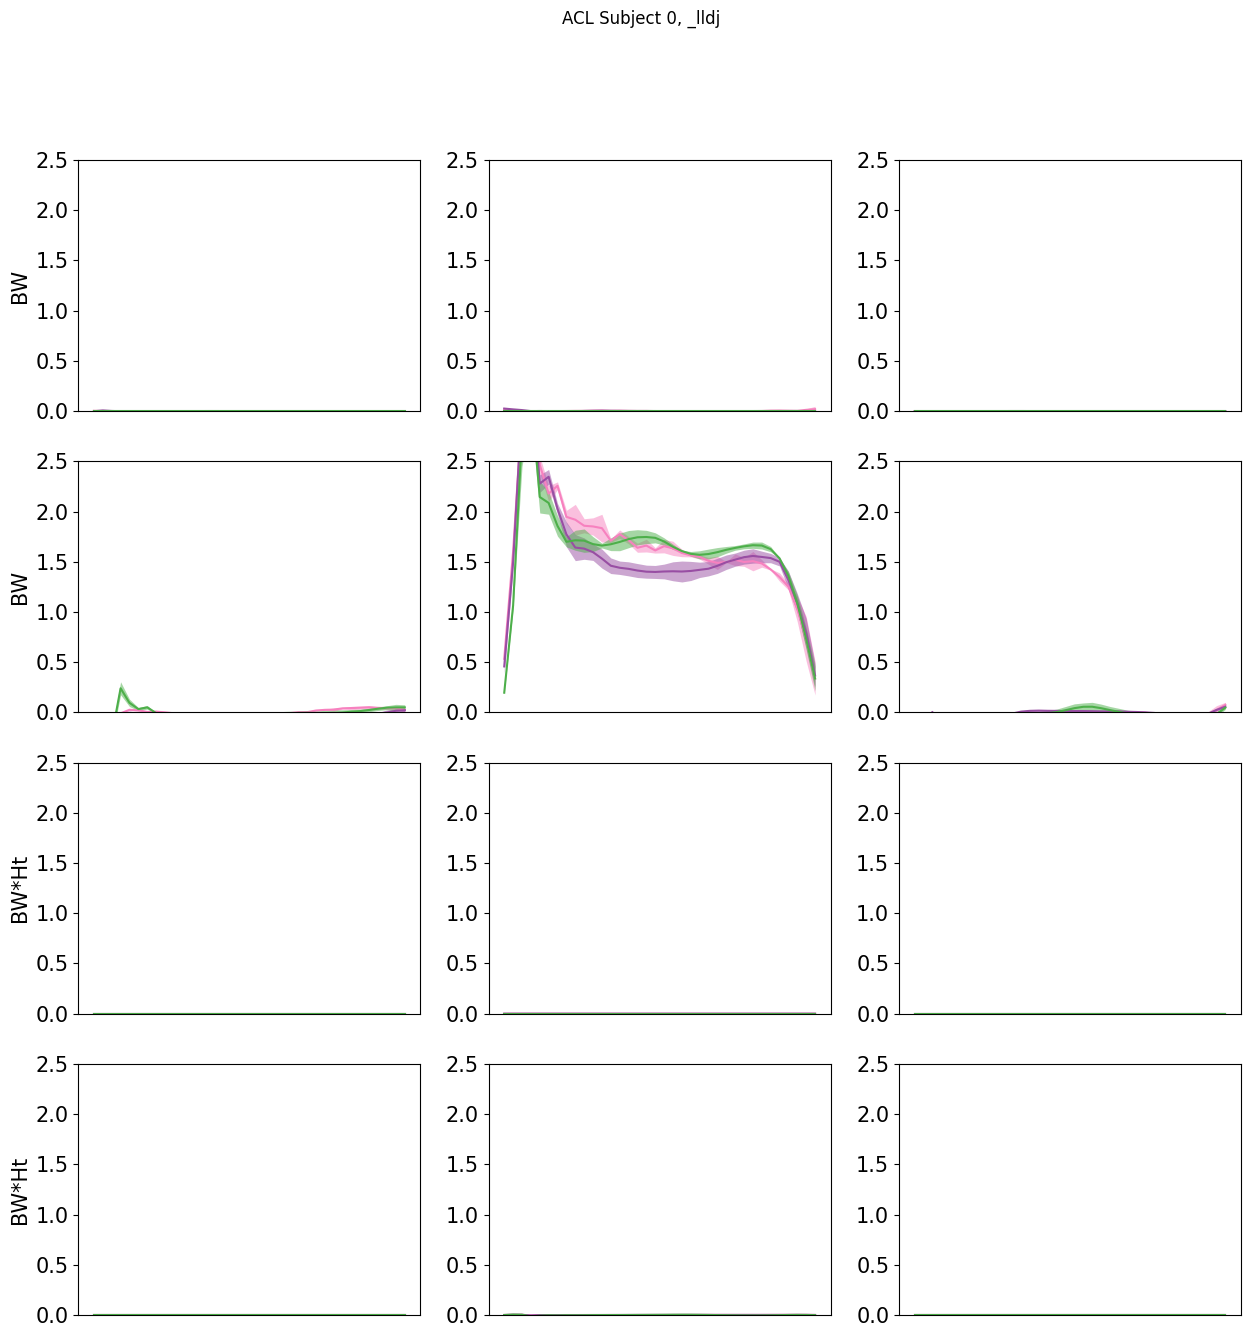

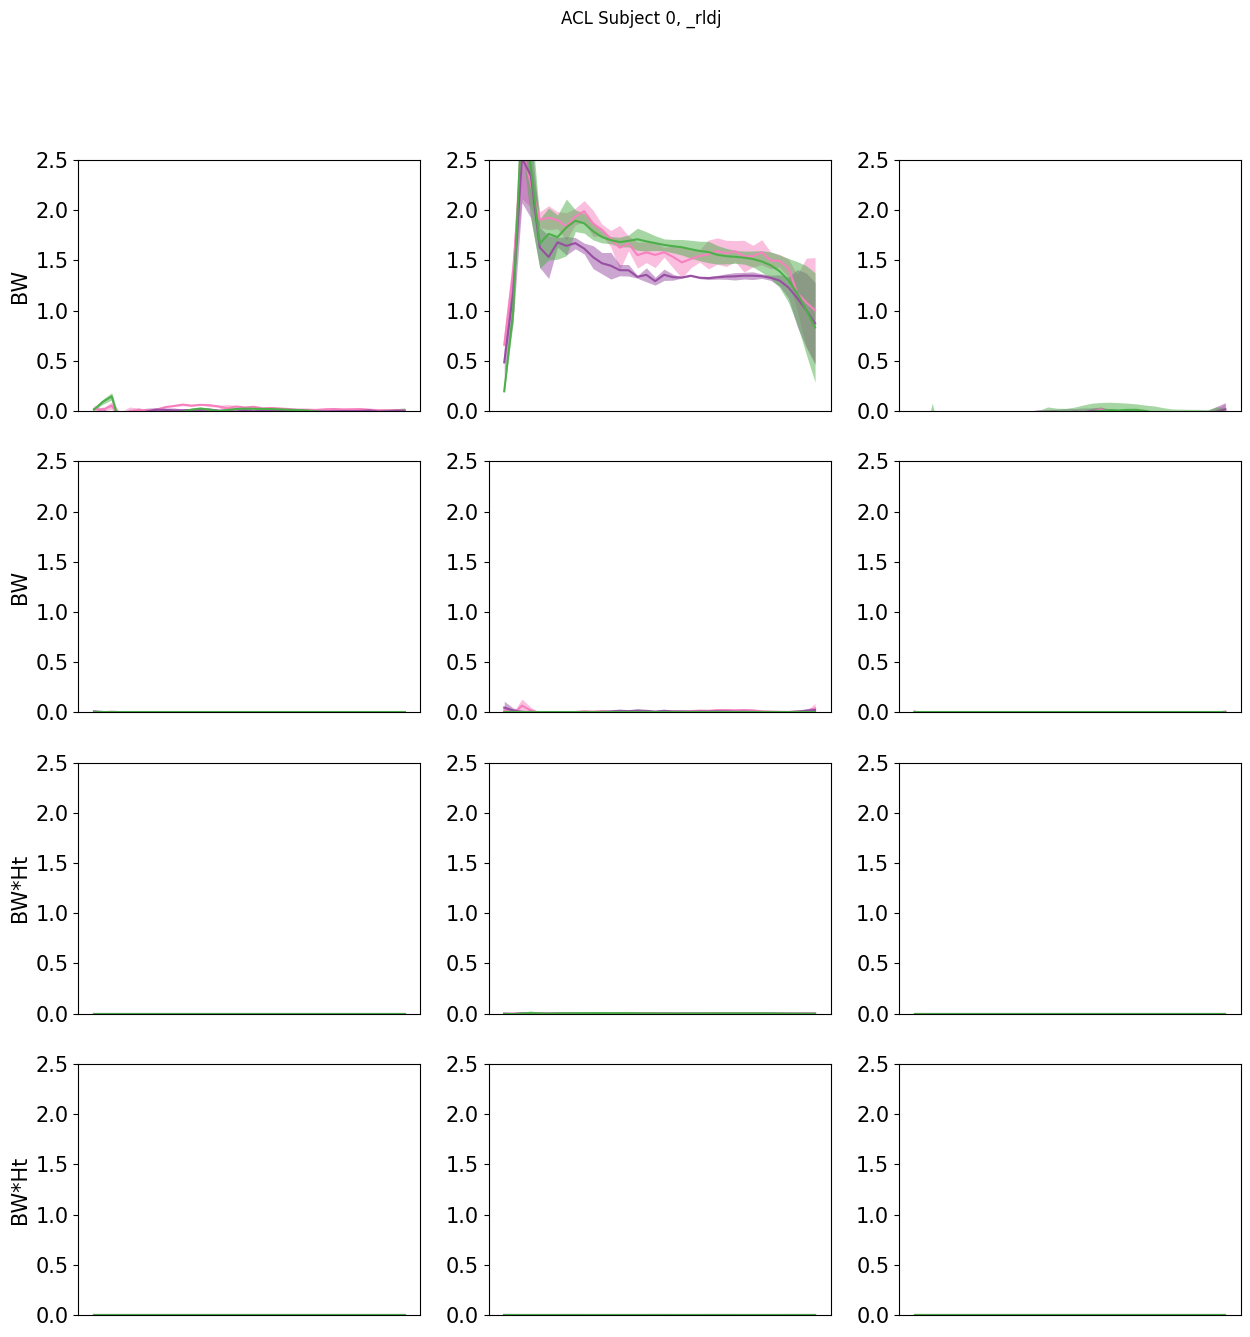

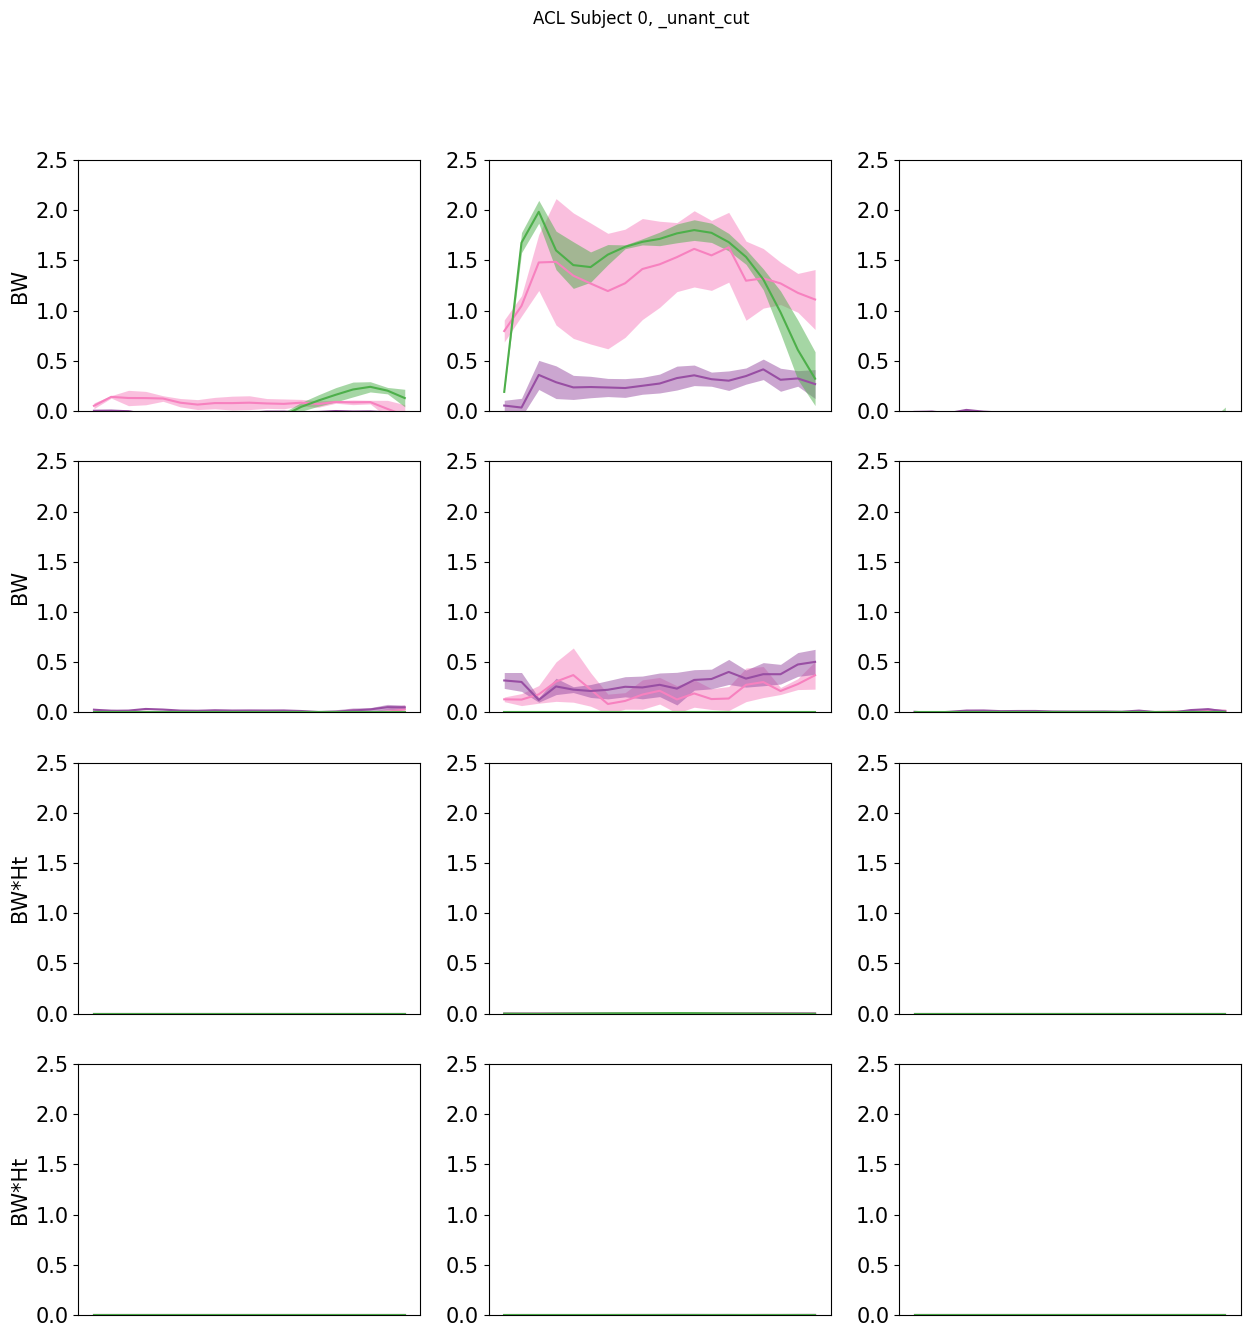

In [ ]:
# # ACL # #
num_subjs = 1
num_trials = 3
acl_tasks = ['_cutting','_dj','_lldj','_rldj','_unant_cut']

# loop over test subjects, and get all steps per subj
for s in range(num_subjs):
    
    # Subset data by subject
    Y_pred_allsubjtasks_withphysics = Y_pred_withphysics_acl[num_trials*5*s:num_trials*5*(s+1), :, :] # shape = 15 x 67 x 12
    Y_pred_allsubjtasks_withoutphysics = Y_pred_withoutphysics_acl[num_trials*5*s:num_trials*5*(s+1), :, :] # shape = 15 x 67 x 12
    Y_true_allsubjtasks = Y_true_acl[num_trials*5*s:num_trials*5*(s+1), :, :]
    
    for task in range(5): # 5 tasks
    
        # Subset data by task.
        Y_pred_allfeats_withphysics = Y_pred_allsubjtasks_withphysics[num_trials*task:num_trials*(task+1),:,:] #  shape = 3 x 67 x 12
        Y_pred_allfeats_withoutphysics = Y_pred_allsubjtasks_withoutphysics[num_trials*task:num_trials*(task+1),:,:] #  shape = 3 x 67 x 12
        Y_true_allfeats = Y_true_allsubjtasks[num_trials*task:num_trials*(task+1),:,:]
    
    
        # Identify the minimum where masking/padding started for the given subject over all trials for given task.
        min_timestep = np.min(np.nonzero(Y_true_allfeats == MASK_VALUE)[1])
        
        # Create subplots for all the outputs for each subject and task.
        fig, axs = plt.subplots(4, 3, figsize=(15,15))
        fig.suptitle(f"ACL Subject {s}, {acl_tasks[task]}")
        plt.tick_params(axis='both', which='both', labelsize=15)
        
        for f in range(12): # loop over all features
            
            # Subset Y_pred and Y_true based on min timesteps and given feature.
            Y_pred_withphysics = Y_pred_allfeats_withphysics[:,0:min_timestep,f] # shape = 3, unmasked time range, 1 feature
            Y_pred_withoutphysics = Y_pred_allfeats_withoutphysics[:,0:min_timestep,f] # shape = 3, unmasked time range, 1 feature
            Y_true = Y_true_allfeats[:,0:min_timestep,f]
                        
            # # PLOTTING # #
            # Add to subplots:
            if f < 3: row = 0
            elif f < 6: row = 1
            elif f < 9: row = 2
            else: row = 3
        
            Y_pred_mean_withphysics = np.mean(Y_pred_withphysics,axis=0)
            Y_pred_std_withphysics = np.std(Y_pred_withphysics,axis=0)
            Y_pred_mean_withoutphysics = np.mean(Y_pred_withoutphysics,axis=0)
            Y_pred_std_withoutphysics = np.std(Y_pred_withoutphysics,axis=0)
            Y_true_mean = np.mean(Y_true,axis=0)
            Y_true_std = np.std(Y_true,axis=0)
            
            # With physics
            axs[row, f%3].plot(Y_pred_mean_withphysics,color='#f781bf',label='prediction (physics)')
            axs[row, f%3].fill_between(range(len(Y_pred_mean_withphysics)), Y_pred_mean_withphysics-Y_pred_std_withphysics, Y_pred_mean_withphysics+Y_pred_std_withphysics,
                                        alpha=0.5, edgecolor='#f781bf', facecolor='#f781bf', linewidth=0)
            # Without physics
            axs[row, f%3].plot(Y_pred_mean_withoutphysics,color='#984ea3',label='prediction (no physics)')
            axs[row, f%3].fill_between(range(len(Y_pred_mean_withoutphysics)), Y_pred_mean_withoutphysics-Y_pred_std_withoutphysics, Y_pred_mean_withoutphysics+Y_pred_std_withoutphysics,
                                        alpha=0.5, edgecolor='#984ea3', facecolor='#984ea3', linewidth=0)
            # True
            axs[row, f%3].plot(np.mean(Y_true,axis=0),color='#4daf4a',label='true')
            axs[row, f%3].fill_between(range(len(Y_true_mean)), Y_true_mean-Y_true_std, Y_true_mean+Y_true_std,
                                        alpha=0.5, edgecolor='#4daf4a', facecolor='#4daf4a', linewidth=0)
            
            #axs[row, f%3].set_title(out_node_names[f])
            #axs[row, f%3].set_xlabel('timesteps')
            axs[row, f%3].set_ylim([0,2.5])
            axs[row, f%3].set_xticks([])
            if (row == 0 or row == 1) and f%3 == 0:
              axs[row, f%3].set_ylabel('BW', fontsize = 15)
            if (row == 2 or row == 3) and f%3 == 0:
              axs[row, f%3].set_ylabel('BW*Ht', fontsize = 15)  
        
        # Save figure for each subject and task.
        figname = 'transformed_preds_acl_subj' + str(s) + acl_tasks[task] + '.png'
        plt.savefig(os.path.join(plot_savedir, figname))